In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
import os
from dotenv import load_dotenv
load_dotenv()

from IPython.display import Image, display

# langchain自身支持的工具
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.openweathermap import OpenWeatherMapAPIWrapper


In [67]:

agent = create_react_agent(
    model = init_chat_model("gpt-4o-mini", temperature=0),
    tools = [
        TavilySearchResults()
    ],
    prompt = "You are a helpful assistant that can answer questions and use tools to find information.",
)

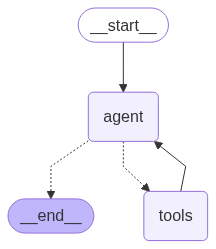

In [68]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
input_message = HumanMessage(content='hello, who is the president of the united states?')
output = agent.invoke({"messages": [input_message]}) 
output_message = output["messages"][-1]
output_message.pretty_print()

================================== Ai Message ==================================

The current President of the United States is **Donald J. Trump**. He assumed office on January 20, 2025, and is the 47th president. The Vice President is **J.D. Vance**.


# streaming

## stream_mode: values, updates, token, messages

In [69]:
agent = create_react_agent(
    model = init_chat_model("gpt-4o-mini", temperature=0),
    tools = [
        TavilySearchResults()
    ],
    prompt = "You are a helpful assistant that can answer questions and use tools to find information.",
)

In [75]:
# stream_mode: values
async for event in agent.astream(input= {'messages': [HumanMessage(content="What's the weather like in San Francisco?")]}, stream_mode="values"):
    print(event)
    event['messages'][-1].pretty_print()

event: {'messages': [HumanMessage(content="What's the weather like in San Francisco?", additional_kwargs={}, response_metadata={}, id='27c4d5b1-91d4-436c-9346-aa1a0cd0dc08')]}
================================ Human Message =================================

What's the weather like in San Francisco?
event: {'messages': [HumanMessage(content="What's the weather like in San Francisco?", additional_kwargs={}, response_metadata={}, id='27c4d5b1-91d4-436c-9346-aa1a0cd0dc08'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mOy10Imn6ZxcfQBywglijMni', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 103, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_t

In [86]:
# stream_mode: updates
async for event in agent.astream(input= {'messages': [HumanMessage(content="What's the weather like in San Francisco?")]}, stream_mode="updates"):
    print(event)
    agent_event = event.get('agent')
    tools_event = event.get('tools',{})
    if agent_event:
        agent_event['messages'][-1].pretty_print()
    if tools_event:
        tools_event['messages'][-1].pretty_print()

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v3BDiOyeVRHW3cJ2r7AyAJbh', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 103, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BlQsvxR3glOSmntvbvs37tLbEQeoj', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2c9afd35-bacb-4c4c-9a76-4a0dbbf1caf2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_v3BDiOyeVRHW3cJ2r7AyAJbh', 'type': 'tool_call'}], u

In [71]:
# stream_mode: tokens
node_to_stream = 'agent'
async for event in agent.astream_events(input= {'messages': [HumanMessage(content="What's the weather like in San Francisco?")]}, stream_mode="tokens"):
    # print(event)
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|",flush=True)


|||||||||||||The| current| weather| in| San| Francisco| is| cloudy| with| over|cast| skies|.| The| daytime| temperature| is| around| |63|°F| (|17|°C|),| and| it| drops| to| about| |54|°F| (|12|°C|)| at| night|.| 

|For| more| detailed| information|,| you| can| check| the| full| weather| report| [|here|](|https|://|we|athers|hog|un|.com|/weather|/|usa|/|ca|/s|an|-fr|anc|isco|/|480|/j|une|/|202|5|-|06|-|25|).||||

In [156]:
# stream_mode: messages
async for event in agent.astream(stream_mode='messages', input ={"messages":[HumanMessage(content="What is the capital of France?")]}):
    print(event)

(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--0b4c6e52-af69-47bf-8ad2-ae5f8da7196d'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:5e95da53-bbb0-c44f-a1b4-194512655d79', 'checkpoint_ns': 'agent:5e95da53-bbb0-c44f-a1b4-194512655d79', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--0b4c6e52-af69-47bf-8ad2-ae5f8da7196d'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:5e95da53-bbb0-c44f-a1b4-194512655d79', 'checkpoint_ns': 'agent:5e95da53-bbb0-c44f-a1b4-194512655d79', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature':

In [157]:
for stream_mode, chunk in agent.stream(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]},
    stream_mode=["updates", "messages", "custom"]
):
    print(chunk)
    print("\n")

(AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_u8eYphWZ2jodY3EWckjiA12U', 'function': {'arguments': '', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={}, id='run--3885707b-b7be-40d4-87db-c20932a25960', tool_calls=[{'name': 'tavily_search_results_json', 'args': {}, 'id': 'call_u8eYphWZ2jodY3EWckjiA12U', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'tavily_search_results_json', 'args': '', 'id': 'call_u8eYphWZ2jodY3EWckjiA12U', 'index': 0, 'type': 'tool_call_chunk'}]), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:cc23e3ca-7296-8add-64b9-2410dc9bfa93', 'checkpoint_ns': 'agent:cc23e3ca-7296-8add-64b9-2410dc9bfa93', 'ls_provider': 'openai', 'ls_model_name': 'gpt-4o-mini', 'ls_model_type': 'chat', 'ls_temperature': 0.0})


(AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'in

# langgraph核心数据结构：State, node, edge, graph

In [127]:
from typing import TypedDict, Annotated
from operator import add


In [141]:
class customState(TypedDict):
    job_name: Annotated[list[str], add]
    job_is_done: bool
    job_well_done: bool

In [142]:
def getJob1(state: customState) -> customState:
    state['job_name'] = ['clean the house']
    state['job_is_done'] = False
    return state

def finishJob1(state: customState) -> customState:
    state['job_is_done'] = True
    state['job_well_done'] = True
    return state

In [143]:
def getJob2(state: customState) -> customState:
    state['job_name'] = ['wash the car']
    state['job_is_done'] = False
    return state

def finishJob2(state: customState) -> customState:
    state['job_is_done'] = True
    state['job_well_done'] = True
    return state

In [144]:
from langgraph.graph import StateGraph, START, END

In [145]:
graph = StateGraph(customState)
graph.add_node('getJob1', getJob1)
graph.add_node('finishJob1', finishJob1)
graph.add_node('getJob2', getJob2)
graph.add_node('finishJob2', finishJob2)

In [146]:
graph.add_edge(START, 'getJob1')
graph.add_edge('getJob1', 'finishJob1')
graph.add_edge('finishJob1', 'getJob2')
graph.add_edge('getJob2', 'finishJob2')
graph.add_edge('finishJob2', END)




In [147]:
graph = graph.compile()

In [148]:
initState = customState(job_name= [''], job_is_done=False, job_well_done=False)

In [150]:
res = graph.invoke(initState)

In [151]:
type(res)

langgraph.pregel.io.AddableValuesDict

In [152]:
res

{'job_name': ['',
  'clean the house',
  '',
  'clean the house',
  'wash the car',
  '',
  'clean the house',
  '',
  'clean the house',
  'wash the car'],
 'job_is_done': True,
 'job_well_done': True}

# Report Generation Agent

In [ ]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    os.getenv("LLM_MODEL", "gpt-4o-mini"), 
    model_provider=os.getenv("LLM_PROVIDER", "openai"),
    
)

In [161]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

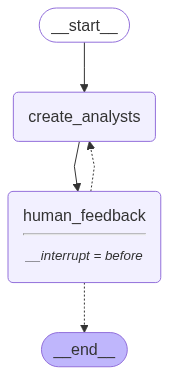

In [162]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [163]:
# Input
max_analysts = 3 
topic = "The Flooding of the Nile Delta in 2023: Causes and Consequences"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Amina El-Sayed
Affiliation: Institute for Environmental Studies
Role: Environmental Scientist
Description: An environmental scientist focusing on hydrology and climate impacts, advocating for sustainable water management practices to protect vulnerable ecosystems.
--------------------------------------------------
Name: Mr. Samir Khaled
Affiliation: Global Policy Institute
Role: Policy Analyst
Description: A policy analyst specializing in climate-induced migration, exploring how flooding can displace populations and affect socio-economic stability in the region.
--------------------------------------------------
Name: Dr. Yasmin Abdel-Mahfouz
Affiliation: Nile Delta Research Center
Role: Geologist
Description: A geologist with expertise in sedimentology, investigating the geological factors contributing to flooding and the long-term consequences for deltaic landscapes.
--------------------------------------------------


In [164]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [165]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f050394-91da-6f1a-8002-fefdda3eeee4'}}

In [166]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Amina El-Sayed
Affiliation: Institute for Environmental Studies
Role: Environmental Scientist
Description: An environmental scientist focusing on hydrology and climate impacts, advocating for sustainable water management practices to protect vulnerable ecosystems.
--------------------------------------------------
Name: Mr. Samir Khaled
Affiliation: Global Policy Institute
Role: Policy Analyst
Description: A policy analyst specializing in climate-induced migration, exploring how flooding can displace populations and affect socio-economic stability in the region.
--------------------------------------------------
Name: Dr. Yasmin Abdel-Mahfouz
Affiliation: Nile Delta Research Center
Role: Geologist
Description: A geologist with expertise in sedimentology, investigating the geological factors contributing to flooding and the long-term consequences for deltaic landscapes.
--------------------------------------------------
Name: Dr. Amina Rashid
Affiliation: National Geographic S

In [167]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f050395-ddc1-6954-8004-db06f9a98a1f'}}

In [168]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [169]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [170]:
final_state.next

()

In [171]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Amina Rashid
Affiliation: National Geographic Society
Role: Environmental Scientist and Cultural Anthropologist
Description: Focused on environmental impacts and the cultural significance of the Nile Delta flooding. Concerned about conservation and its implications for local communities and ecosystems.
--------------------------------------------------
Name: Mr. Thomas Bennett
Affiliation: Global Climate Initiative
Role: Climate Policy Analyst
Description: Analyzes the socio-political responses to climate change induced flooding. Examines the effectiveness of international policies and local governance in addressing these crises.
--------------------------------------------------
Name: Ms. Leila Hassan
Affiliation: EcoInnovate Labs
Role: Social Entrepreneur and Innovator
Description: Startup founder with a focus on developing innovative solutions to mitigate flooding impacts. Interested in technology application and entrepreneurial strategies for sustainable development.
----

In [ ]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [ ]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [ ]:
final_state.next

()

In [ ]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Analyst
Description: Dr. Carter focuses on evaluating emerging technologies and their potential impact on various industries. She is particularly interested in how LangGraph can streamline processes and improve efficiency in tech-driven companies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Green Ventures
Role: Startup Advisor
Description: Michael Thompson is an advisor for early-stage startups, helping them navigate the challenges of growth and innovation. He is keen on understanding how LangGraph can provide a competitive edge to startups by enhancing their operational capabilities.
--------------------------------------------------
Name: Sarah Lee
Affiliation: Global Enterprises Ltd.
Role: Business Strategist
Description: Sarah Lee specializes in developing strategic business plans for large enterprises. She is interested in how LangGraph can be integrated into existi

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [ ]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [173]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [174]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [175]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

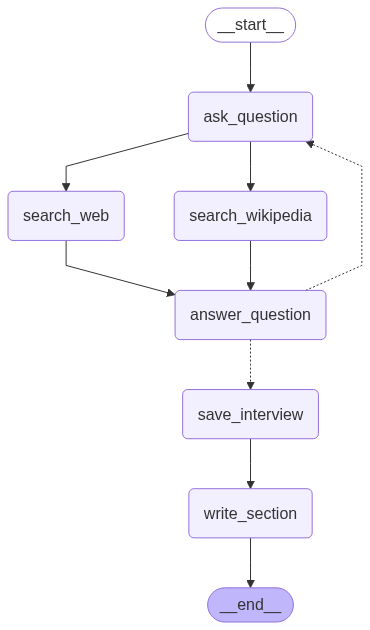

In [176]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [190]:
# Pick one analyst
analysts[0]

Analyst(affiliation='National Geographic Society', name='Dr. Amina Rashid', role='Environmental Scientist and Cultural Anthropologist', description='Focused on environmental impacts and the cultural significance of the Nile Delta flooding. Concerned about conservation and its implications for local communities and ecosystems.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [ ]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])



In [ ]:
stream_mode = 'token'
async for event in interview_graph.astream_events(input = {"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, config=thread, stream_mode=stream_mode):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == 'answer_question':
        data = event["data"]
        print(data["chunk"].content, end="|")

{'event': 'on_chain_start', 'data': {'input': {'analyst': Analyst(affiliation='National Geographic Society', name='Dr. Amina Rashid', role='Environmental Scientist and Cultural Anthropologist', description='Focused on environmental impacts and the cultural significance of the Nile Delta flooding. Concerned about conservation and its implications for local communities and ecosystems.'), 'messages': [HumanMessage(content='So you said you were writing an article on The Flooding of the Nile Delta in 2023: Causes and Consequences?', additional_kwargs={}, response_metadata={}, id='5016b844-c041-4d5c-ab00-0c2c457f8b7b')], 'max_num_turns': 2}}, 'name': 'Conduct Interviews', 'tags': [], 'run_id': 'c4d6e383-834c-4f1c-8223-cfc6cc948f78', 'metadata': {'thread_id': '1'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='So you said you were writing an article on The Flooding of the Nile Delta in 2023: Causes and Consequences?', additional_kwargs={},

In [202]:
stream_mode = 'tokens'
async for event in interview_graph.astream_events(input = {"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, config=thread, stream_mode=stream_mode):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == 'write_section':
        data = event["data"]
        print(data["chunk"].content, end="")

## The Vulnerability of the Nile Delta: Environmental Impacts and Cultural Significance of Rising Flooding Risks

### Summary
The Nile Delta, an essential ecological and cultural region in Egypt, is facing increasingly severe threats from climate change, particularly from rising sea levels and related flooding risks. The Intergovernmental Panel on Climate Change (IPCC) projects that substantial portions of the Delta could be submerged by 2100, jeopardizing the livelihoods of millions who rely on its rich agricultural land and the Nile River for survival and income. Alexandria, Egypt's second-largest city, exemplifies these vulnerabilities, as it sits on the brink of significant flooding and saltwater intrusion that threaten local freshwater supplies and agricultural viability [1][2].

Reports indicate that as sea levels rise, combined with the ongoing land subsidence in the Delta due to upstream damming and natural gas extraction, up to 25% of the Delta may be submerged, impacting arou

In [186]:
from pprint import pprint
pprint(interview)

{'analyst': Analyst(affiliation='National Geographic Society', name='Dr. Amina Rashid', role='Environmental Scientist and Cultural Anthropologist', description='Focused on environmental impacts and the cultural significance of the Nile Delta flooding. Concerned about conservation and its implications for local communities and ecosystems.'),
 'context': ['<Document '
             'href="https://reliefweb.int/report/egypt/climate-and-mobility-case-study-january-2023-alexandria-egypt-al-max"/>\n'
             'It would also cause buildings to collapse and salination of '
             'farmland in the nearby Nile Delta region, destroying livelihoods '
             'and triggering\n'
             '</Document>\n'
             '\n'
             '---\n'
             '\n'
             '<Document '
             'href="https://space4water.org/local-perspectives-case-studies/sea-level-rise-and-potential-predictions-sinking-delta-egypt"/>\n'
             'According to a recent report by the Interna

# SDK

In [82]:
import langgraph_sdk
from langgraph_sdk import get_client, get_sync_client
client_async = get_client(url="http://127.0.0.1:2024")

In [85]:
threads = await client_async.threads.search()
threads

[{'thread_id': '57144e39-2042-4e4f-94ff-49c2a5aa47f7',
  'created_at': '2025-06-24T14:41:34.003328+00:00',
  'updated_at': '2025-06-24T14:41:42.747087+00:00',
  'metadata': {'graph_id': 'agent',
   'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
  'status': 'idle',
  'config': {'configurable': {'thread_id': '57144e39-2042-4e4f-94ff-49c2a5aa47f7',
    'x-auth-scheme': 'langsmith',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36 Edg/137.0.0.0',
    'x-request-id': '06aa5be7-7c2a-4152-a205-23bd52657cca',
    'langgraph_auth_user': None,
    'langgraph_auth_user_id': '',
    'langgraph_auth_permissions': [],
    'langgraph_request_id': '06aa5be7-7c2a-4152-a205-23bd52657cca',
    '__request_start_time_ms__': 1750776094142,
    '__after_seconds__': 0}},
  'values': {'messages': [{'content': '你好，今天南京天气如何',
     'additional_kwargs': {},
     'response_metadata': {},
     'type': 'human',
     'name': No

In [86]:
assistants = await client_async.assistants.search()
assistants

[{'assistant_id': 'e0b3fb87-7b2b-45fc-94d0-fc006bd032d2',
  'graph_id': 'agent',
  'config': {},
  'metadata': {},
  'name': 'Untitled',
  'created_at': '2025-06-24T12:39:07.584994+00:00',
  'updated_at': '2025-06-24T12:39:07.584994+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '6456fda8-9c40-47d0-8321-9230e218370f',
  'graph_id': 'agent',
  'config': {},
  'metadata': {},
  'name': 'Untitled',
  'created_at': '2025-06-24T12:39:01.539276+00:00',
  'updated_at': '2025-06-24T12:39:01.539276+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-06-24T12:05:16.571359+00:00',
  'updated_at': '2025-06-24T12:05:16.571359+00:00',
  'version': 1,
  'description': None}]

In [108]:
from langgraph_sdk import get_client
client_async = get_client(url="http://127.0.0.1:2024")
async for chunk in client_async.runs.stream(
    thread_id=None,
    assistant_id="e0b3fb87-7b2b-45fc-94d0-fc006bd032d2",
    input={"messages": [{"role": "user", "content": "How about the weather in San Francisco?"}]},
    stream_mode= "events", # "messages","custom", "updates", "events"],
    metadata={"name":"my_run"},
    config=None,
    interrupt_before=None,
    interrupt_after=None,
    feedback_keys=None,
    webhook="https://my.fake.webhook.com",
    multitask_strategy="interrupt"
):
    event = chunk.data
    # print(event)
    if event and event.get("event",'') == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == 'agent':
        data = event["data"]
        # print(data)
        print(data['chunk']['content'], end='', flush=True)

The current weather in San Francisco is as follows:

- **Daytime Temperature**: 66°F (approximately 19°C)
- **Nighttime Temperature**: 54°F (approximately 12°C)
- **Precipitation**: 0%
- **Wind Speed**: 12 mph
- **UV Index**: 11 (very high)

For detailed forecasts and updates, you can refer to the following sources:

- [WeatherShogun](https://weathershogun.com/weather/usa/ca/san-francisco/today/480)
- [Weather25](https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=June)

Let me know if you need more information!

In [13]:
thread = await client.threads.search()
for thread_item in thread:
    thread_id = thread_item['thread_id']
    await client.threads.delete(thread_id)

In [16]:
assistant = await client.assistants.search()
for assistant_item in assistant:
    assistant_id = assistant_item['assistant_id']
    await client.assistants.delete(assistant_id)